In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import yfinance as yf

## Graph generation based on fundamental correlation of stock prices

In [2]:
stocks = pd.read_csv("data/tickers_list.csv",index_col=0)
stocks

,Name,Sector
Symbol,,
AAPL,Apple Inc.,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe Inc.,Information Technology
...,...,...
V,Visa Inc.,Financials
VZ,Verizon,Communication Services
WFC,Wells Fargo,Financials


## Buildin hybrid graph

### Building fundamental graph

In [3]:
fundamentals = pd.read_csv("data/fundamentals.csv", index_col=0)
fundamentals

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,3845545787392,34.839360,28.438677,52.143856,7.47,9.15127,4.991,0.1367,1.093,0.52,0.106527,45481135,9.348,0.26915
ABBV,388895277056,166.696960,15.454298,-147.183940,1.32,14.23811,-1.495,4.9015,0.350,3.73,0.245219,5765709,7.581,0.04004
ABT,216930811904,15.658291,21.953518,4.253489,7.96,5.67745,29.303,0.2915,0.720,1.72,0.112466,6263467,5.121,0.31880
ACN,174234222592,23.219833,18.881872,5.601053,12.10,14.87988,50.162,0.5017,1.249,1.49,-0.196110,3833124,2.436,0.10761
ADBE,138989125632,19.619759,12.459217,11.755104,16.70,26.29780,27.873,0.0000,1.526,0.12,-0.182497,3865345,5.861,0.29997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,662340763648,33.614105,23.798693,17.707151,10.21,14.42096,19.382,0.2314,0.815,0.68,0.139613,6169808,16.935,0.50145
VZ,167982399488,8.494670,8.311723,1.599165,4.69,4.79323,24.913,0.5805,0.327,6.02,0.061385,27494220,2.469,0.14428
WFC,304198778880,15.644151,13.663426,1.817277,6.07,6.94994,52.254,0.2718,1.088,2.14,0.360414,14538816,4.123,0.26629


In [4]:
for i, column in enumerate(fundamentals.columns, 1):
        col_mean = fundamentals[column].mean()
        col_std = fundamentals[column].std()
        if col_std != 0:  # Avoid division by zero for constant columns
            fundamentals[column] = (fundamentals[column] - col_mean) / col_std
        else:
            fundamentals[column] = 0
    

In [5]:
fundamentals

,marketCap,trailingPE,forwardPE,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,
AAPL,4.130510,-0.120814,0.111831,1.885271,-0.156867,-0.178701,-0.100762,-0.472011,0.336703,-1.008148,-0.271423,1.295401,0.256547,0.704610
ABBV,-0.082367,1.366604,-0.364201,-6.160681,-0.527218,0.008404,-0.100895,5.125769,-1.359250,1.009531,0.170816,-0.375687,0.097946,-1.233174
ABT,-0.291953,-0.337186,-0.125927,-0.047844,-0.127359,-0.306475,-0.100261,-0.290149,-0.514698,-0.253876,-0.252487,-0.354744,-0.122857,1.124543
ACN,-0.343990,-0.251888,-0.238539,0.006551,0.121951,0.032010,-0.099831,-0.043202,0.692784,-0.398444,-1.236428,-0.457004,-0.363856,-0.661676
ADBE,-0.386946,-0.292499,-0.474006,0.254962,0.398962,0.451985,-0.100290,-0.632609,1.325057,-1.259572,-1.193019,-0.455648,-0.056437,0.965281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.250902,-0.134636,-0.058279,0.495219,0.008136,0.015130,-0.100465,-0.360755,-0.297853,-0.907578,-0.165924,-0.358684,0.937537,2.669373
VZ,-0.351610,-0.417995,-0.626061,-0.154987,-0.324278,-0.338999,-0.100351,0.049374,-1.411750,2.448934,-0.415365,0.538573,-0.360894,-0.351525
WFC,-0.185593,-0.337346,-0.429858,-0.146183,-0.241174,-0.259670,-0.099788,-0.313293,0.325290,0.010120,0.538133,-0.006545,-0.212435,0.680420


In [6]:
fundamentals_corr = fundamentals.transpose().corr(method="pearson")
fundamentals_corr = (fundamentals_corr - (fundamentals_corr == 1))  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,-0.416977,0.049918,-0.013144,0.147295,-0.337895,0.079369,-0.249173,-0.157465,0.841902,...,0.215841,0.071413,-0.129743,-0.299006,-0.319698,0.266874,-0.232782,-0.022731,0.440080,-0.095260
ABBV,-0.416977,0.000000,-0.232709,-0.129568,-0.436995,0.084223,-0.177552,-0.012726,-0.065086,-0.209825,...,-0.386255,0.050963,-0.250825,0.230954,0.016991,-0.325920,0.204404,-0.214129,-0.066191,0.261658
ABT,0.049918,-0.232709,0.000000,-0.335236,0.337968,-0.119004,-0.404864,0.270112,0.534369,-0.310822,...,0.545212,-0.248309,0.763569,-0.455204,0.372335,0.895372,-0.028398,0.494755,-0.546694,-0.214408
ACN,-0.013144,-0.129568,-0.335236,0.000000,0.616605,-0.069312,0.037762,-0.304542,0.187658,0.145469,...,-0.140634,0.471846,0.249823,0.532099,-0.071482,-0.236631,-0.293022,-0.387662,-0.169483,-0.338122
ADBE,0.147295,-0.436995,0.337968,0.616605,0.000000,-0.446559,0.160799,-0.348858,0.252228,0.144475,...,0.581624,0.000739,0.661033,-0.175483,0.018088,0.517781,-0.613507,0.221042,-0.546766,-0.796676
AIG,-0.337895,0.084223,-0.119004,-0.069312,-0.446559,0.000000,-0.613671,0.791900,0.148959,-0.529678,...,-0.665287,0.470081,-0.039361,0.507468,0.258714,-0.364961,0.738340,-0.287394,0.000612,0.778654
AMD,0.079369,-0.177552,-0.404864,0.037762,0.160799,-0.613671,0.000000,-0.746382,-0.527974,0.435373,...,0.507350,-0.548047,-0.429699,-0.308085,-0.308125,-0.189797,-0.566296,0.305568,0.231158,-0.583096
AMGN,-0.249173,-0.012726,0.270112,-0.304542,-0.348858,0.791900,-0.746382,0.000000,0.396632,-0.646985,...,-0.453866,0.307370,0.223203,0.183586,0.247087,0.084552,0.581867,-0.132130,-0.142282,0.626323
AMT,-0.157465,-0.065086,0.534369,0.187658,0.252228,0.148959,-0.527974,0.396632,0.000000,-0.520027,...,0.006402,0.048398,0.759086,0.317357,0.499950,0.475025,0.196784,0.025524,-0.552341,-0.012525


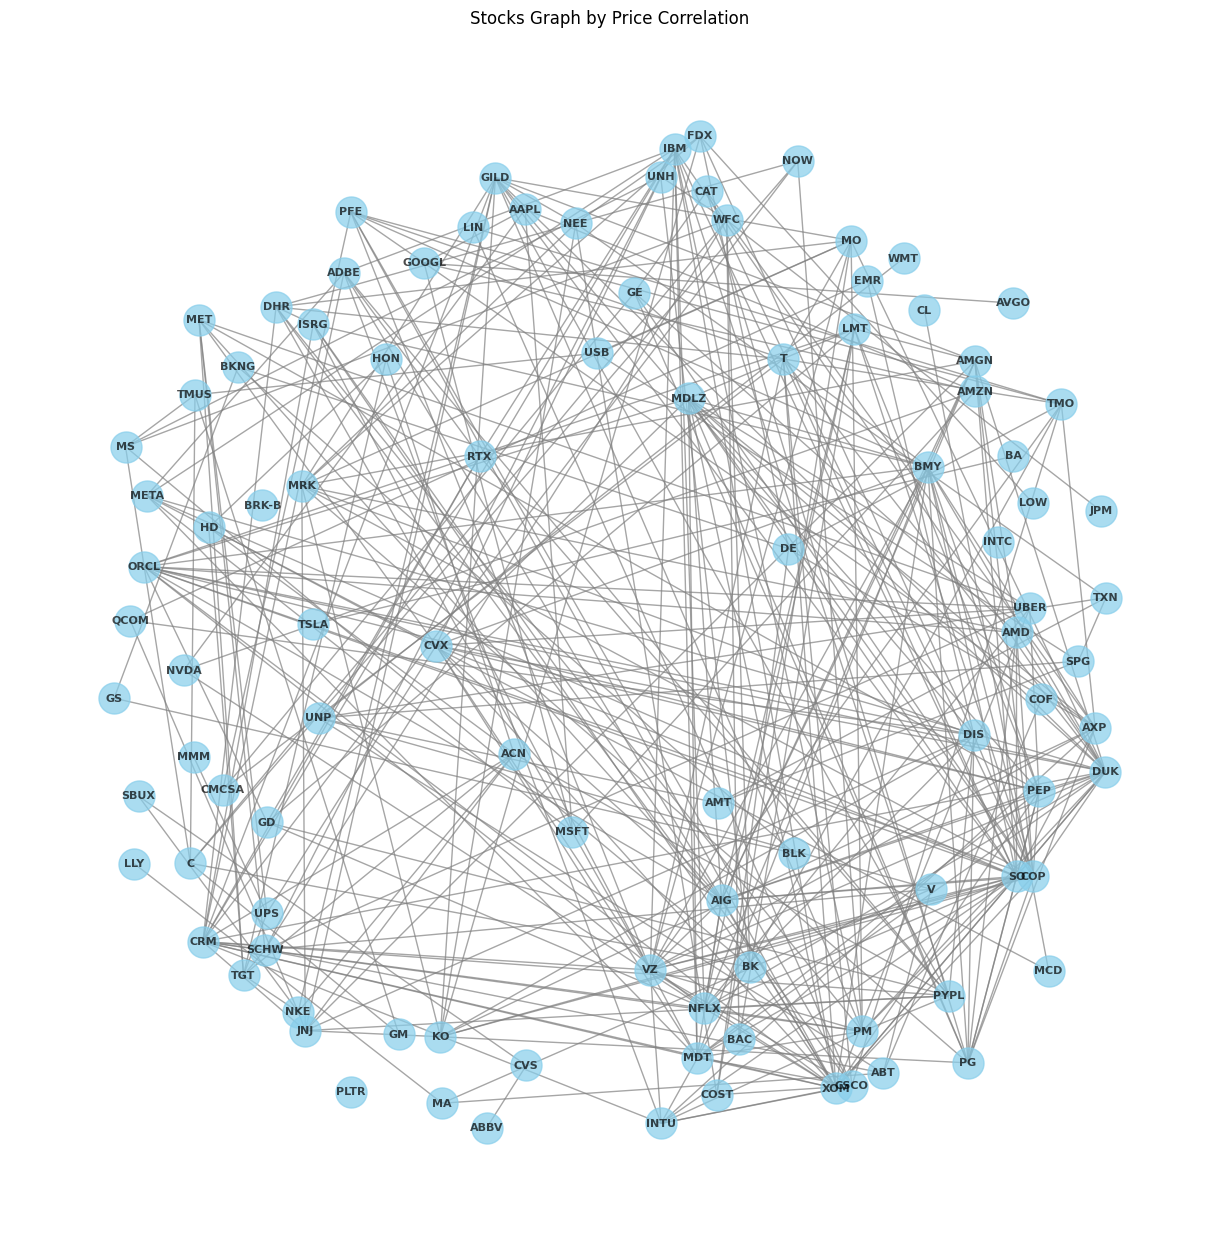

In [ ]:
fundamentals_corr_np = fundamentals_corr.to_numpy()

adj_fundamentals_corr = (fundamentals_corr_np * (abs(fundamentals_corr_np) > .7).astype(int))

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))


# 2. CONVERT to a NetworkX Graph Object (This is the missing step)
G = fundamentals_corr_graph

# 3. Now draw the Graph object 'G', not the matrix
plt.figure(figsize=(12, 12)) # Increased height for better visibility

# Calculate layout based on the Graph object G
pos = nx.spring_layout(G, k=0.7, iterations=20) 

nx.draw(
    G,                  # Pass G here
    pos=pos,            # Use the calculated layout
    with_labels=True, 
    node_size=500, 
    node_color='skyblue', 
    font_size=8, 
    font_weight='bold', 
    font_color='black',
    edge_color='gray',  # Added explicitly to ensure edges are visible
    alpha=0.7           # Transparency
)

plt.title('Stocks Graph by Price Correlation')
plt.show()

### Building sector graph

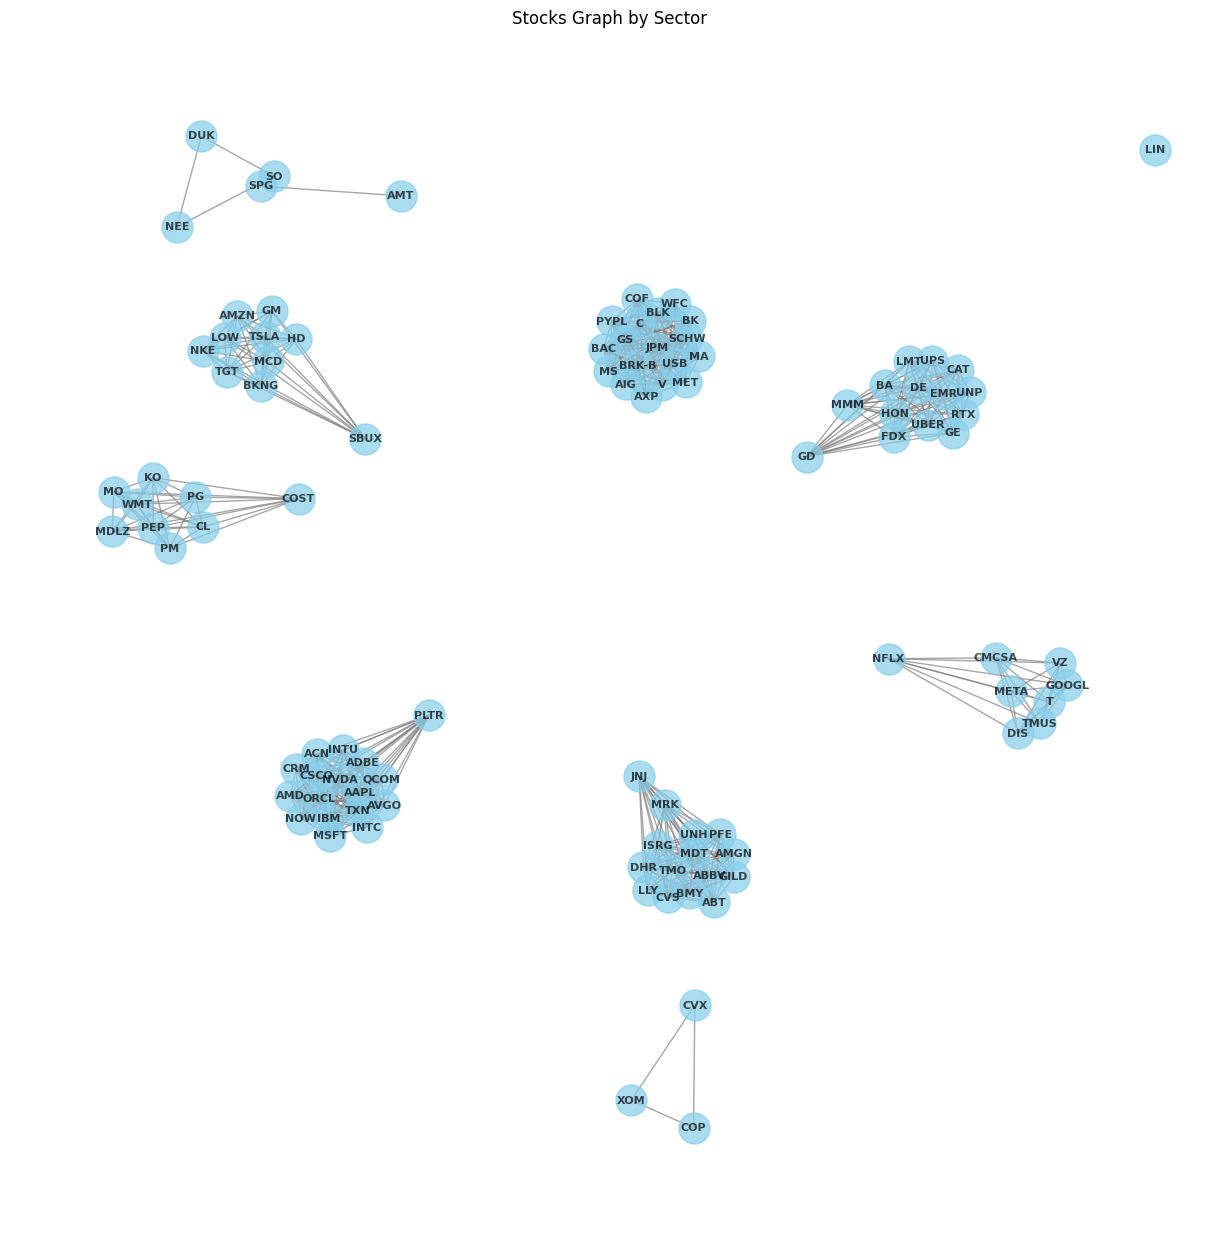

In [20]:
share_sector = pd.get_dummies(stocks[["Sector"]]).transpose().corr().to_numpy().astype(int) - np.eye(len(stocks), dtype=int)
stocks_graph = nx.from_numpy_array(share_sector)
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks.index)))

# 2. CONVERT to a NetworkX Graph Object (This is the missing step)
G = stocks_graph

# 3. Now draw the Graph object 'G', not the matrix
plt.figure(figsize=(12, 12)) # Increased height for better visibility

# Calculate layout based on the Graph object G
pos = nx.spring_layout(G, k=0.15, iterations=20) 

nx.draw(
    G,                  # Pass G here
    pos=pos,            # Use the calculated layout
    with_labels=True, 
    node_size=500, 
    node_color='skyblue', 
    font_size=8, 
    font_weight='bold', 
    font_color='black',
    edge_color='gray',  # Added explicitly to ensure edges are visible
    alpha=0.7           # Transparency
)

plt.title('Stocks Graph by Sector')
plt.show()




### Merging graphs

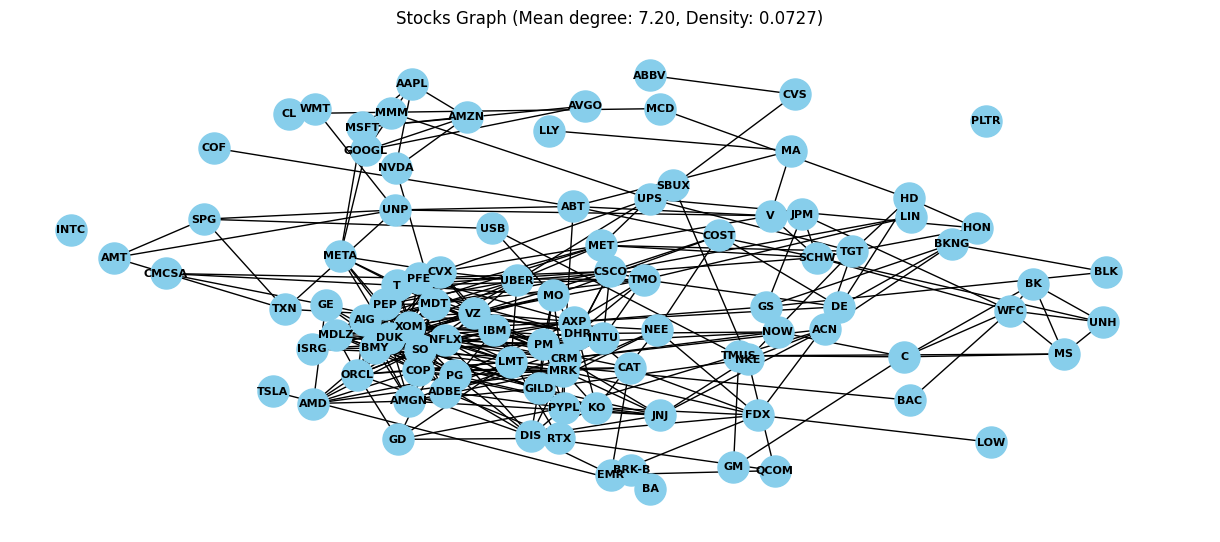

In [21]:
corr_threshold, sector_bonus = .7, .05

adj = abs(fundamentals_corr_np) + share_sector * sector_bonus
adj = adj * (abs(adj) > corr_threshold)  
adj = adj / adj.max()

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title(f'Stocks Graph (Mean degree: {np.mean([degree for node, degree in graph.degree]):.2f}, Density: {nx.density(graph):.4f})')
plt.show()

## Reading pearson correlation generated graph

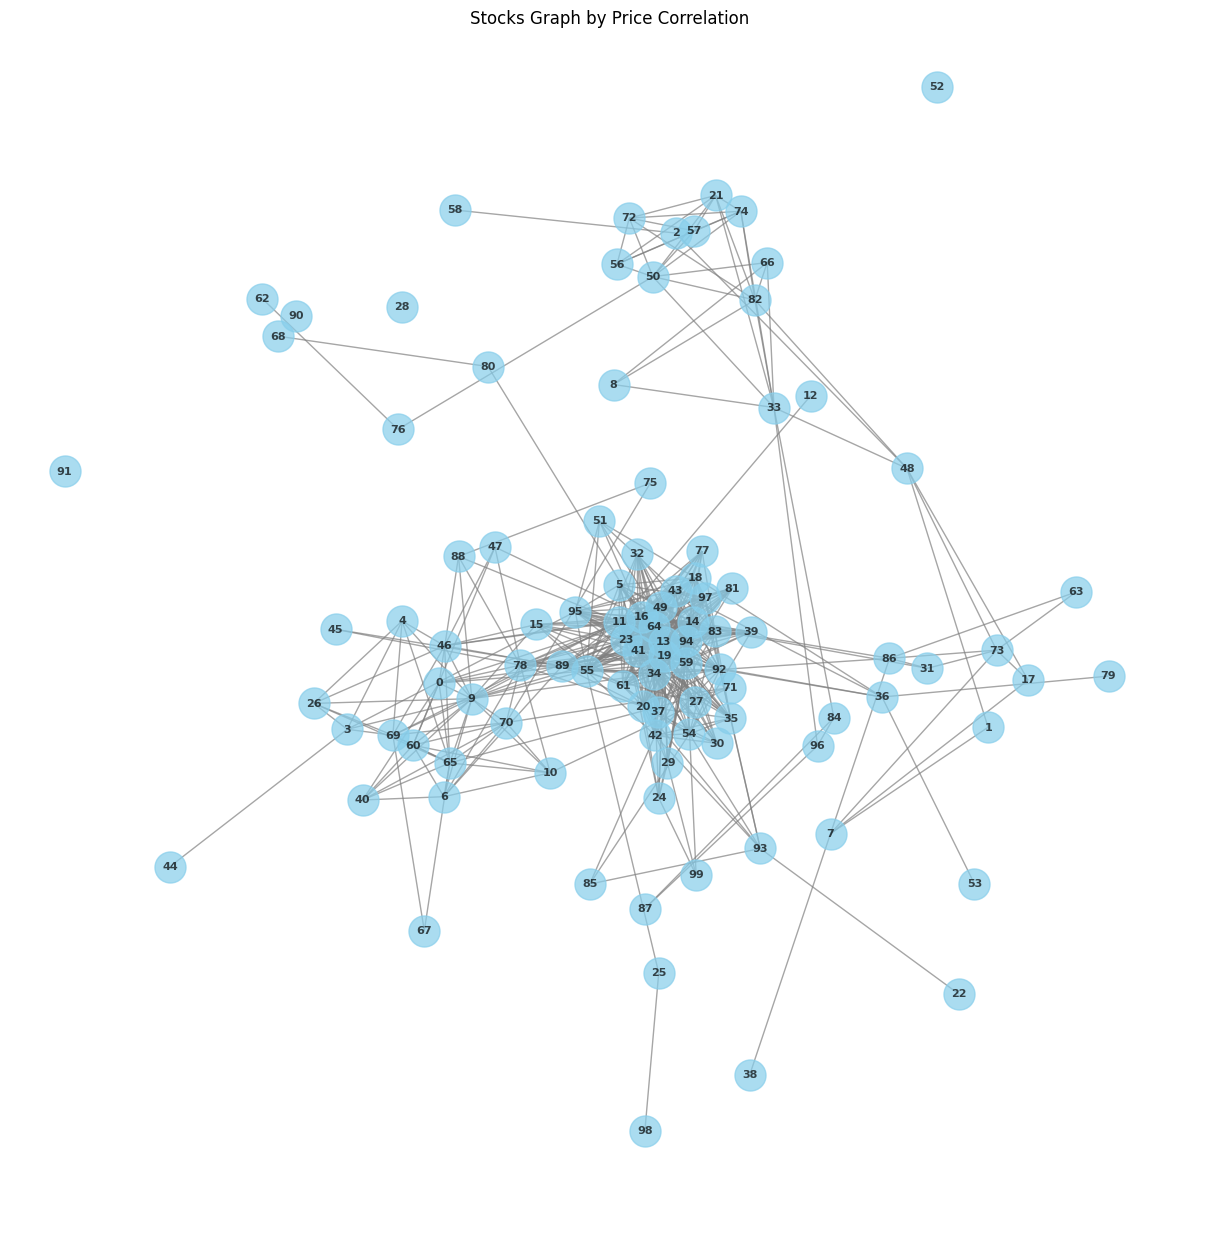

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the matrix
adj_matrix = np.load("data/pearson_adj.npy")

# 2. CONVERT to a NetworkX Graph Object (This is the missing step)
G = nx.from_numpy_array(adj_matrix)

# 3. Now draw the Graph object 'G', not the matrix
plt.figure(figsize=(12, 12)) # Increased height for better visibility

# Calculate layout based on the Graph object G
pos = nx.spring_layout(G, k=0.15, iterations=20) 

nx.draw(
    G,                  # Pass G here
    pos=pos,            # Use the calculated layout
    with_labels=True, 
    node_size=500, 
    node_color='skyblue', 
    font_size=8, 
    font_weight='bold', 
    font_color='black',
    edge_color='gray',  # Added explicitly to ensure edges are visible
    alpha=0.7           # Transparency
)

plt.title('Stocks Graph by Price Correlation')
plt.show()

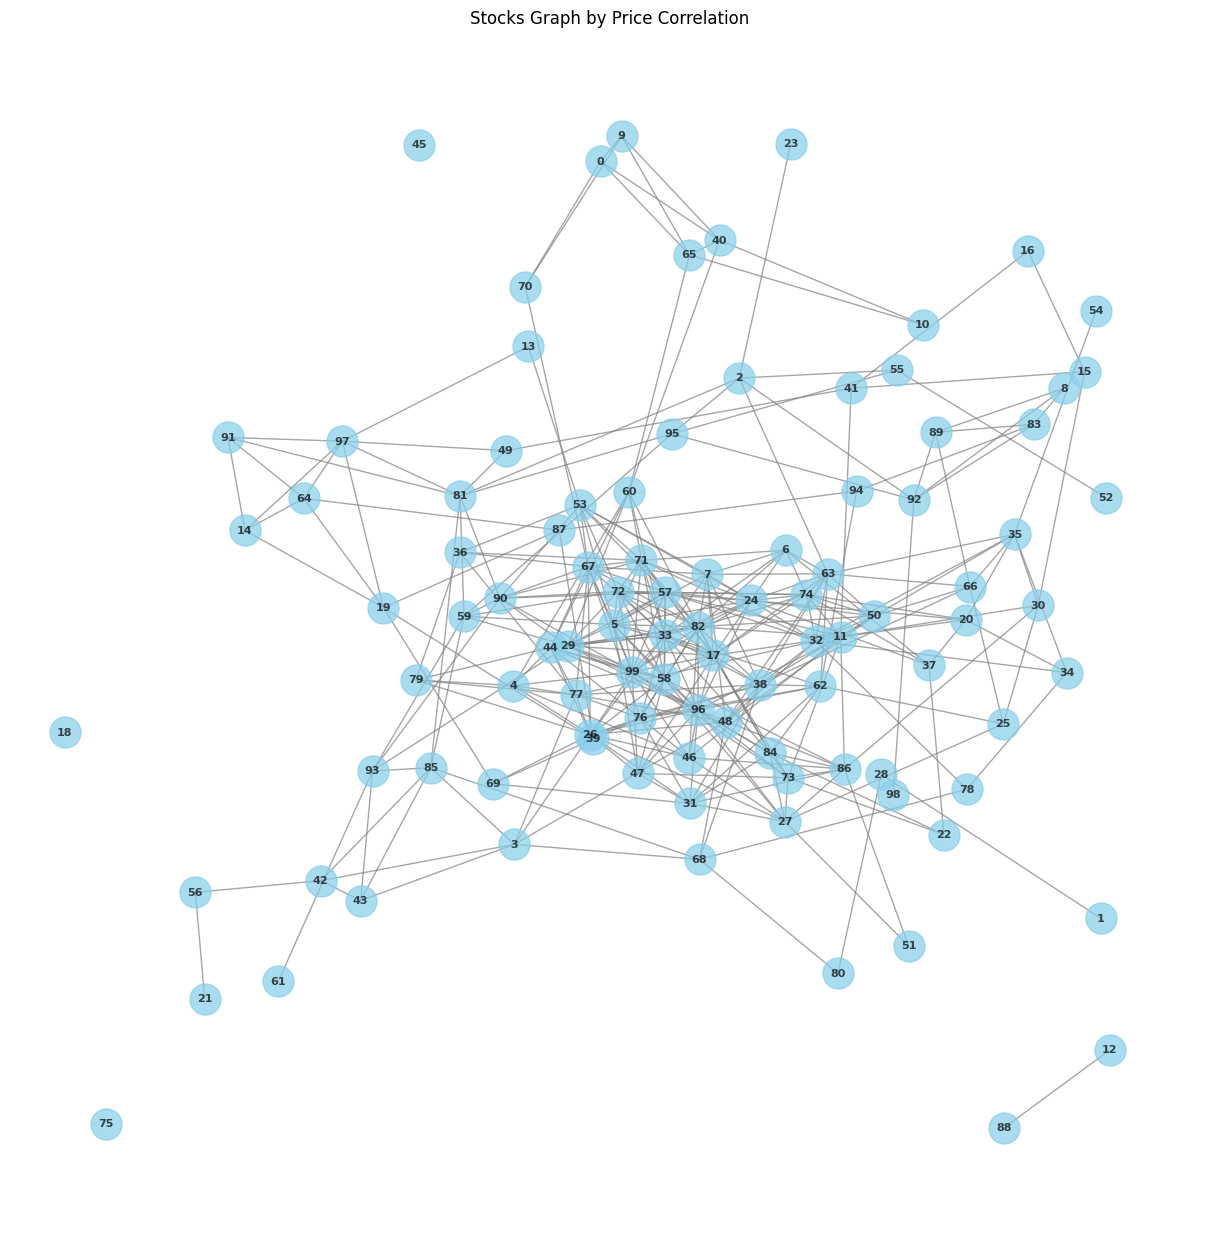

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the matrix
adj_matrix = np.load("data/hybrid_adj.npy")

# 2. CONVERT to a NetworkX Graph Object (This is the missing step)
G = nx.from_numpy_array(adj_matrix)

# 3. Now draw the Graph object 'G', not the matrix
plt.figure(figsize=(12, 12)) # Increased height for better visibility

# Calculate layout based on the Graph object G
pos = nx.spring_layout(G, k=0.15, iterations=20) 

nx.draw(
    G,                  # Pass G here
    pos=pos,            # Use the calculated layout
    with_labels=True, 
    node_size=500, 
    node_color='skyblue', 
    font_size=8, 
    font_weight='bold', 
    font_color='black',
    edge_color='gray',  # Added explicitly to ensure edges are visible
    alpha=0.7           # Transparency
)

plt.title('Stocks Graph by Price Correlation')
plt.show()